In [1]:
import pandas as pd
import numpy as np
import json

In [3]:
bact_diag =  pd.read_csv("../MIMIC-IV-SOFA/pn_bact/sofa_diagnoses.csv", index_col=0)
bact_diag["label"] = "no"
virus_diag =  pd.read_csv("../MIMIC-IV-SOFA/pn_virus/sofa_diagnoses.csv", index_col=0)
virus_diag["label"] = "yes"
diag = pd.concat((bact_diag,virus_diag), axis=0)

In [5]:
cxr_date = pd.read_csv("mimic-iv-cxr-2/mimic-cxr-2.0.0-metadata.csv",)
admission = pd.read_csv("../MIMIC-IV/mimic-iv-2/hosp/admissions.csv")

admission = pd.merge(admission, diag.loc[:,["hadm_id","label"]].drop_duplicates())
admission["StartDate"] = [int(i[0:11].replace("-", "")) for i in admission["admittime"]]
admission["EndDate"] = [int(i[0:11].replace("-", "")) for i in admission["dischtime"]]
admission = admission.loc[:,["subject_id", "hadm_id", "StartDate", "EndDate", "label"]]
cxr_date = pd.merge(cxr_date, diag[["subject_id"]].drop_duplicates())
cxr_date = cxr_date.loc[:,["subject_id","study_id","StudyDate"]].drop_duplicates()
cxr_hadm = pd.merge(admission, cxr_date)
cxr_hadm = cxr_hadm.loc[(cxr_hadm["StudyDate"]-cxr_hadm["StartDate"]>=-1) & (cxr_hadm["StudyDate"]-cxr_hadm["StartDate"]<=1)]
cxrlist = pd.read_csv("mimic-iv-cxr-2/cxr-record-list.csv")
report_train = pd.read_csv("mimic-iv-cxr-2/mimic_train_impressions.csv", index_col=0)
report_test = pd.read_csv("mimic-iv-cxr-2/mimic_test_impressions.csv",)
cxrreport = pd.concat((report_train,report_test), axis=0)
cxrreports = pd.merge(cxrlist,cxrreport).drop_duplicates()
diag_cxr = pd.merge(cxr_hadm,cxrreport).drop_duplicates()

In [6]:
df = diag_cxr
train_set = {
    "data": [{
        'paragraphs': [],
        'title': "LungB"
    }],
    "version": "LungB"
}
train_qa = []
im = {"yes": False, "no": True}

df = df.loc[df["report"].isnull()==False, :]
for idx in df.index:
    
    qa = {
        'qas': [{
            'id': str(df.loc[idx, "study_id"]),
            'question': "Is patient's cxr report consistent with viral infection?",
            'is_impossible': im[df.loc[idx, "label"]],
            'answers': df.loc[idx, "label"]
        }],
        'context': df.loc[idx, "report"]
    }
    train_qa.append(qa)

train_set['data'][0]["paragraphs"] = train_qa
json.dump(train_set, open("mimic-iv-cxr-2/train_set.json", "w"))
df.to_csv("mimic-iv-cxr-2/train_set.csv")

# chetexprt


In [7]:
a = pd.read_csv("mimic-iv-cxr-2/mimic-cxr-2.0.0-chexpert.csv")

In [8]:
chetexprt = pd.merge(diag_cxr, a)
chetexprt = chetexprt.fillna(0)
chetexprt.loc[chetexprt["label"]=="no","label"]= int(0)
chetexprt.loc[chetexprt["label"]=="yes","label"]= int(1)

In [9]:
file = chetexprt
dis_var = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']

In [10]:
for i in dis_var:
    file.loc[file[i]==-1,i] = 1

In [11]:
acc_l = []
prepro_l = []
label_l = []

from sklearn.model_selection import KFold
kf = KFold(n_splits = 10)

for train_set, eval_set in kf.split(file):
    
    X_train = file.iloc[train_set][dis_var]
    Y_train = file.iloc[train_set]["label"].astype('int')
    X_test = file.iloc[eval_set][dis_var]
    Y_test = file.iloc[eval_set]["label"].astype('int')

    from sklearn.linear_model import LogisticRegression

    clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
    # 测试模型
    prepro = clf.predict_proba(X_test)
    acc = clf.score(X_test,Y_test)
    
    acc_l.append(acc)
    prepro_l.extend(prepro[:,-1].tolist()) 
    label_l.extend(Y_test.tolist())
print(np.mean(acc_l))

0.7850186722393143


0.000000 0.000000 1.650780
0.006399 0.033333 0.650780
0.014078 0.068966 0.649859
0.020904 0.102299 0.645629
0.028157 0.140230 0.644381
0.033703 0.174713 0.643167
0.040102 0.214943 0.641264
0.043942 0.251724 0.640473
0.048635 0.289655 0.639450
0.052474 0.325287 0.638905
0.057167 0.366667 0.633156
0.057594 0.366667 0.580498
0.058020 0.367816 0.550355
0.060154 0.367816 0.527620
0.060154 0.368966 0.525476
0.060580 0.371264 0.518419
0.060580 0.372414 0.516084
0.061860 0.372414 0.502104
0.063140 0.372414 0.486884
0.063567 0.374713 0.484840
0.064420 0.374713 0.483899
0.064846 0.374713 0.482193
0.066553 0.375862 0.481961
0.067406 0.378161 0.481885
0.068686 0.378161 0.481742
0.068686 0.379310 0.479229
0.069539 0.379310 0.476670
0.069966 0.380460 0.476513
0.070392 0.380460 0.475638
0.071246 0.385057 0.471103
0.071672 0.385057 0.465002
0.072099 0.388506 0.464646
0.072099 0.393103 0.462433
0.072952 0.393103 0.461536
0.073379 0.394253 0.458680
0.073805 0.396552 0.452349
0.074232 0.396552 0.451843
0

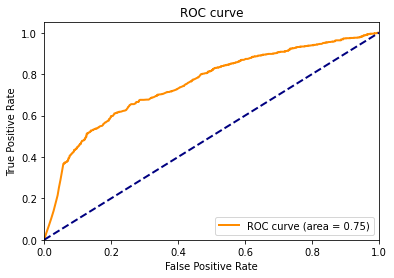

0.30720723830455426

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thersholds = roc_curve(label_l, prepro_l)
for i, value in enumerate(thersholds):
    print("%f %f %f" % (fpr[i], tpr[i], value))

roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

thersholds[(tpr-fpr).tolist().index(max(tpr-fpr))]

In [18]:
predi_l = []
for i in prepro_l:
    if i>0.5:
        predi_l.append(1)
    else:
        predi_l.append(0)

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(label_l,
                        predi_l,
                        normalize=True,
                        sample_weight=None)
precision = precision_score(label_l,
                            predi_l,
                            labels=None,
                            pos_label=1,
                            average='binary',
                            sample_weight=None,
                            zero_division='warn')
recall = recall_score(label_l,
                    predi_l,
                    labels=None,
                    pos_label=1,
                    average='binary',
                    sample_weight=None,
                    zero_division='warn')
f1 = f1_score(label_l,
            predi_l,
            labels=None,
            pos_label=1,
            average='binary',
            sample_weight=None,
            zero_division='warn')